In [1]:
!ls

transfer_learning_pytorch.ipynb


In [ ]:
!wget -nc grebvm2.epfl.ch/lin/food/Food-5K.zip


In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sys, os
import imageio
from glob import glob

In [4]:
!unzip -qq -o Food-5K.zip

In [5]:
!ls

Food-5K  Food-5K.zip  __MACOSX	sample_data


In [6]:
!ls Food-5K/training

0_0.jpg     0_1387.jpg	0_422.jpg  0_809.jpg   1_1195.jpg  1_230.jpg  1_617.jpg
0_1000.jpg  0_1388.jpg	0_423.jpg  0_80.jpg    1_1196.jpg  1_231.jpg  1_618.jpg
0_1001.jpg  0_1389.jpg	0_424.jpg  0_810.jpg   1_1197.jpg  1_232.jpg  1_619.jpg
0_1002.jpg  0_138.jpg	0_425.jpg  0_811.jpg   1_1198.jpg  1_233.jpg  1_61.jpg
0_1003.jpg  0_1390.jpg	0_426.jpg  0_812.jpg   1_1199.jpg  1_234.jpg  1_620.jpg
0_1004.jpg  0_1391.jpg	0_427.jpg  0_813.jpg   1_119.jpg   1_235.jpg  1_621.jpg
0_1005.jpg  0_1392.jpg	0_428.jpg  0_814.jpg   1_11.jpg    1_236.jpg  1_622.jpg
0_1006.jpg  0_1393.jpg	0_429.jpg  0_815.jpg   1_1200.jpg  1_237.jpg  1_623.jpg
0_1007.jpg  0_1394.jpg	0_42.jpg   0_816.jpg   1_1201.jpg  1_238.jpg  1_624.jpg
0_1008.jpg  0_1395.jpg	0_430.jpg  0_817.jpg   1_1202.jpg  1_239.jpg  1_625.jpg
0_1009.jpg  0_1396.jpg	0_431.jpg  0_818.jpg   1_1203.jpg  1_23.jpg   1_626.jpg
0_100.jpg   0_1397.jpg	0_432.jpg  0_819.jpg   1_1204.jpg  1_240.jpg  1_627.jpg
0_1010.jpg  0_1398.jpg	0_433.jpg  0_81.jpg    1_1205.j

In [7]:
!mv Food-5K/* .

<function matplotlib.pyplot.imshow>

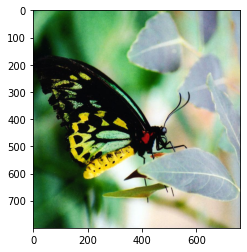

In [8]:
#Let's look at an image
plt.imshow(imageio.imread('training/0_717.jpg'))
plt.imshow

<function matplotlib.pyplot.imshow>

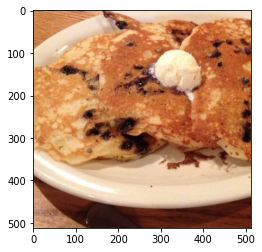

In [9]:
#Let's look at an food image
plt.imshow(imageio.imread('training/1_717.jpg'))
plt.imshow

In [10]:
!mkdir data

In [11]:
#making directories to store the data keras style
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/test/nonfood
!mkdir data/train/food
!mkdir data/test/food

In [12]:
#moving the images
#training will be train set and validation will be test set
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*jpg data/test/food

In [13]:
#Normalize mean and std are standardized for Imagenet
train_transform = transforms.Compose([
                                      transforms.RandomResizedCrop(size=256, scale=(0.8,1.0)),
                                      transforms.RandomRotation(degrees=15),
                                      transforms.ColorJitter(),
                                      transforms.CenterCrop(size=224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
test_transform =  transforms.Compose([
                                      transforms.RandomResizedCrop(size=256),                                    
                                      transforms.CenterCrop(size=224),                                      
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [14]:
train_dataset = datasets.ImageFolder(
    'data/train',
    transform = train_transform
)
test_dataset = datasets.ImageFolder(
    'data/test',
    transform = test_transform
)

In [15]:
batch_size=128
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = batch_size
)

In [16]:
#define the model
model = models.vgg16(pretrained=True)

#freeze vgg weights
for param in model.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [17]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
#we want to replace the classifier
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [19]:
n_features = model.classifier[0].in_features
n_features

25088

In [20]:
# We are doing binary classification
model.classifier = nn.Linear(n_features, 2)


In [21]:
#print newly defined model
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [23]:
#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [24]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      #move data to gpu
      inputs, targets = inputs.to(device), targets.to(device)

      #zero the parameter gradients
      optimizer.zero_grad()

      #forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      #backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    #get train and test loss
    train_loss = np.mean(train_loss) #little misleading

    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    #save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train loss: {train_loss:.4f}, \
       Test loss: {test_loss:.4f}, Duration: {dt}')
    
  return train_losses, test_losses

In [25]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [28]:
import torch
torch.cuda.get_device_name(0)


'Tesla K80'

In [29]:
train_losses, test_losses = batch_gd(
    model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    epochs=5,
)

Epoch 1/5, Train loss: 0.3208,        Test loss: 0.1355, Duration: 0:01:15.251434
Epoch 2/5, Train loss: 0.0716,        Test loss: 0.1313, Duration: 0:01:14.729732
Epoch 3/5, Train loss: 0.0445,        Test loss: 0.1084, Duration: 0:01:12.805784
Epoch 4/5, Train loss: 0.0307,        Test loss: 0.1073, Duration: 0:01:12.707405
Epoch 5/5, Train loss: 0.0166,        Test loss: 0.1358, Duration: 0:01:12.039916


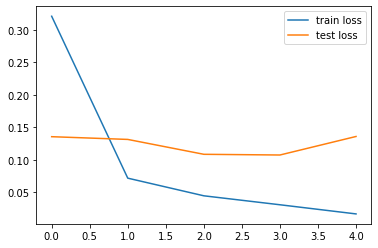

In [30]:
plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [31]:
#Accuracy

n_correct =0.
n_total =0.

for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  #forward pass
  outputs = model(inputs)

  #get prediction
  _, predictions = torch.max(outputs,1)

  #update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct/n_total

n_correct =0.
n_total =0.

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  #forward pass
  outputs = model(inputs)

  #get prediction
  _, predictions = torch.max(outputs,1)

  #update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]
test_acc = n_correct/n_total

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9957, Test acc: 0.9710
